In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")


In [3]:
def maxmin1(x):
 
    max_value = x.max().item()
    print ('1:', max_value)
    min_value = x.min().item()  
    print ('2:', min_value)
    x_normalized = (x - min_value) / (max_value - min_value)
     

    return x_normalized

In [4]:
def partition(RG_GRFf_file_path, RG_GRFl_file_path, abn_ratio):

    with open(RG_GRFf_file_path, 'rb') as file:
        GRFf = pickle.load(file).astype(np.float32)
    file.close()

    with open(RG_GRFl_file_path, 'rb') as file:
        GRFl = pickle.load(file).astype(np.float32)
    file.close()
    
    # stat indice for 0(abnormal)/1(healthy)
    GRFl_0_indice = np.where(GRFl==0)
    GRFl_1_indice = np.where(GRFl==1)
    
    # print ('6:', GRFl_0_indice)
    # print ('7:', GRFl_1_indice)
    
    # select the corresponding features for indice
    GRFl_features_0 = GRFf[list(GRFl_0_indice[0])]
    GRFl_features_1 = GRFf[list(GRFl_1_indice[0])]
    
    # select the corresponding features for indice
    GRFl_0 = GRFl[list(GRFl_0_indice[0])]
    GRFl_1 = GRFl[list(GRFl_1_indice[0])]

    # print (GRFl_features_0.shape)
    
    # print (GRFl_features_1.shape)
    
    # 67977 abnoraml / 16574 healthy, 因此至少
    # print (round(len(GRFl_0)/len(GRFl_1),3))
    
    # print (GRFl_0.shape)
    
    # print (GRFl_1.shape)

    # 训练样本
    #### Portation of  0(abnormal)
    total_sample_size = GRFl_features_0.shape[0]
    total_sample_range = list(np.arange(0, total_sample_size))
    train_sample_size = int(GRFl_features_0.shape[0] * abn_ratio)
    # 训练
    train_indices = np.random.choice(GRFl_features_0.shape[0], size = train_sample_size, replace=False)
    # print ('1:', indices)
    # print ('2:', type(indices))
    # print ('3:', indices.shape)
    GRFl_features_0_portion_train = GRFl_features_0[train_indices]
    GRFl_0_portion_train = GRFl_0[train_indices]
    # print ('4:', GRFl_features_0_portion)
    # print ('5:', type(GRFl_features_0_portion))
    # print ('6:', GRFl_features_0_portion.shape)
    # print ('44:', GRFl_0_portion)
    # print ('7:', type(GRFl_0_portion))
    # print ('8:', GRFl_0_portion.shape)    
    #### Concatenate of  0(abnormal) + 1(healthy)
    ## 3398 + 16574 = 19972
    GRFf_train = np.concatenate((GRFl_features_0_portion_train, GRFl_features_1),axis = 0)
    GRFl_train = np.concatenate((GRFl_0_portion_train, GRFl_1),axis = 0)
    # print ('9:', type(GRFf)) 
    # print ('10:', GRFf.shape) 
    # print ('11:', type(GRFl)) 
    # print ('12:', GRFl.shape)
    
    # 测试样本
    test_indices = []
    for e in total_sample_range:
        if e not in train_indices:
            # test_indices.append(np.where(total_sample_range==e)[0][0])
            test_indices.append(e)
            
    ##
    test_indices = np.array(test_indices)
    GRFl_features_0_portion_test = GRFl_features_0[test_indices]
    GRFl_0_portion_test = GRFl_0[test_indices]
    ##
    GRFf_test = np.concatenate((GRFl_features_0_portion_test, GRFl_features_1), axis = 0)
    GRFl_test = np.concatenate((GRFl_0_portion_test, GRFl_1), axis = 0)

    ####
    print ('13:', GRFf_train.shape)
    print ('14:', GRFl_train.shape)
    print ('15:', GRFf_test.shape)
    print ('16:', GRFl_test.shape)

    return GRFf_train, GRFl_train, GRFf_test, GRFl_test

In [5]:
def balance_01(X, Y):
    GRFf = X
    GRFl = Y
    # 使用SMOTE进行过采样时正样本和负样本要放在一起，生成比例1：1
    smo = SMOTE(n_jobs=-1)
    # 这里必须是fit_resample()，有些版本是fit_sample()无法运行
    #### reshape, 用KNN来插值维度必须是1D
    GRFf_1d = GRFf.reshape(GRFf.shape[0], -1)
    # print ('test1:', GRFf.shape)
    # 特征维度
    GRFf_1d_fnum = GRFf.shape[1]
    
    # print ('1:', GRFf_1d.shape)
    GRFf_re, GRFl_re = smo.fit_resample(GRFf_1d, GRFl)
    
    # print ('2:', GRFf_re.shape)
    # print ('3:', GRFl_re.shape)
    # 样本
    GRFf_re = GRFf_re.reshape(GRFf_re.shape[0], GRFf_1d_fnum, -1)
    #
    # print ('4:', GRFf_re.shape)
    
    
    #### test the distribution proportion
    #
    #
    GRFl_re_0_indice = np.where(GRFl_re==0)
    GRFl_re_1_indice = np.where(GRFl_re==1)
    
    #### 1:1，少数类样本0(疾病人群)数量增加为16574(0.05)
    # print ('5:', len(list(GRFl_re_0_indice[0]))) 
    # print ('6:', len(list(GRFl_re_1_indice[0]))) 
    # print ('7:', GRFf_re)
    #
    #
    #
    print ('17:', len(list(GRFl_re_0_indice[0])))
    print ('18:', len(list(GRFl_re_1_indice[0])))    
    
    return GRFf_re, GRFl_re

In [ ]:
#### DataSet 

In [6]:
# ---------------1、load---------------
RG_GRFf_file_path = 'DataSet1/GRFf.pkl'
RG_GRFl_file_path = 'DataSet1/GRFl.pkl'

# part ratio，这里健康样本是陪衬，一直要加上
abn_ratio = 0.3 # 30%训练
# abn_ratio = 0.2 # 20%训练
# abn_ratio = 0.1 # 10%
# abn_ratio = 0.05 # 5%


# 按比例切分样本，但目前是固定10%:90%, 20%:80%, 30%:70%, 但目前的10% 20% 30%必须变起来写成随机化的(sampler???)
GRFf_train_part, GRFl_train_part, GRFf_val_part, GRFl_val_part  =  partition(RG_GRFf_file_path, RG_GRFl_file_path, abn_ratio)
# 平衡训练集样本量，正负样本数为1:1
GRFf_train_ba, GRFl_train_ba = balance_01(GRFf_train_part, GRFl_train_part)
# 平衡训练集样本量，正负样本数为1:1
GRFf_val_ba, GRFl_val_ba = balance_01(GRFf_val_part, GRFl_val_part)

# ------------------------ 2、normlization max-min scaler------------------------
GRFf_train = torch.from_numpy(GRFf_train_ba)
GRFf_train = maxmin1(GRFf_train)

GRFf_val = torch.from_numpy(GRFf_val_ba)
GRFf_val = maxmin1(GRFf_val)

#
GRFl_train = torch.from_numpy(GRFl_train_ba)
GRFl_val = torch.from_numpy(GRFl_val_ba)

# ------------------------ 3、Tensor Dataset------------------------
train_set = TensorDataset(GRFf_train, GRFl_train)
val_set = TensorDataset(GRFf_val, GRFl_val)





13: (19972, 10, 101)
14: (19972,)
15: (81153, 10, 101)
16: (81153,)
17: 16574
18: 16574
17: 64579
18: 64579
1: 1.6862719058990479
2: -0.43713119626045227
1: 1.6962571144104004
2: -0.43713119626045227


In [7]:
# -----------------4、dataloader------------------------

abn_ratio = 0.01 # 1% 
val_percent = 0.3
train_batch_size = 32
test_batch_size = 48
workers  = 3
pin_memory = True

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = train_batch_size,
    shuffle = True,
    num_workers = workers,
    pin_memory = pin_memory,
    sampler = None
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size = test_batch_size,
    shuffle = False,
    num_workers = workers,
    pin_memory = pin_memory
)

print ('11:', train_loader)
print ('12:', val_loader)

print ('13:', len(train_loader))
print ('14:', len(val_loader))

11: <torch.utils.data.dataloader.DataLoader object at 0x00000263A27B4390>
12: <torch.utils.data.dataloader.DataLoader object at 0x00000263DABAAC90>
13: 1036
14: 2691


In [ ]:
### VGG19 Model

In [12]:
class VGG19(nn.Module):

    # initialize model
    def __init__(self, img_size=224, input_channel=10, num_class=1):
        super().__init__()

        # 64
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=input_channel, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),  # default parameter：nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            nn.ReLU(inplace=True)
        )

        # 64
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3,stride=1,padding=1)
        )

        # 128
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
        )

        # 128
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        )

        # 256
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
        )

        # 256
        self.conv6 = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
        )

        # 256
        self.conv7 = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
        )

        # 256
        self.conv8 = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        )

        # 512
        self.conv9 = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
        )

        # 512
        self.conv10 = nn.Sequential(
            nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
        )

        # 512
        self.conv11 = nn.Sequential(
            nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
        )

        # 512
        self.conv12 = nn.Sequential(
            nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        )

        # 512
        self.conv13 = nn.Sequential(
            nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
        )

        # 512
        self.conv14 = nn.Sequential(
            nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
        )

        # 512
        self.conv15 = nn.Sequential(
            nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
        )

        # 512
        self.conv16 = nn.Sequential(
            nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        )

        # 4096
        self.fc17 = nn.Sequential(
            nn.Linear(int(512 * 101), 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5)  # 默认就是0.5
        )

        # 4096
        self.fc18 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5)
        )

        # 4096
        self.fc19 = nn.Sequential(
            nn.Linear(4096, num_class)
        )

        self.conv_list = [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5, self.conv6, self.conv7,
                          self.conv8, self.conv9, self.conv10, self.conv11, self.conv12, self.conv13, self.conv14,
                          self.conv15, self.conv16]

        self.fc_list = [self.fc17, self.fc18, self.fc19]

        self.sigmoid = nn.Sigmoid()

        print("VGG Model Initialize Successfully!")

    # forward
    def forward(self, x):
        #
        for conv in self.conv_list:    # 16 CONV
            x = conv(x)
        # BS * xx
        output = x.view(x.size()[0], -1)
        for fc in self.fc_list:        # 3 FC
            output = fc(output)

        X = self.sigmoid(output).squeeze()

        # print ('1:', X.shape)
        # print ('2:', X)
        return X


# if __name__ == '__main__':
#     vgg19 = VGG19()
#     print(vgg19)   # print model of vgg19


In [ ]:
### DataSet API

In [ ]:
### Setting

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = VGG19().to(device)
print (net)
net=net.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.00001)
# 0.1 reduce / 10 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


###
# epochs = 100
epochs =3
# acc

# acc
def accuracy_fn(y_true, y_pred):
    y_pred = y_pred>0.5
    y_pred = torch.where(y_pred, 1, 0)
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100
    return acc


# confusion matrix
# 混淆矩阵计算
def calculate_performance_metrics(y_true, y_pred, labels):

    # 预测矩阵转换0 1矩阵
    y_pred = y_pred>0.5
    y_pred = torch.where(y_pred,1,0)

    # print ('0:', y_pred)
    # print ('00:', y_true)
    # print ('0_:', y_pred.shape)
    # print ('00_:', y_true.shape)
    

    # 再转换为numpy类型
    # y_pred = y_pred.detach().numpy()
    y_pred = y_pred.cpu().numpy()
    
    # y_true = y_true.detach().numpy()
    y_true = y_true.cpu().numpy()

    # print ('11:', type(y_pred))
    # print ('22:', type(y_true))
    # print ('33:', y_pred.shape)
    # print ('44:', y_true.shape)

    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    # 混淆矩阵画图
#     fx = plot_cm(cm)
    
    # 计算精度
    precision = precision_score(y_true, y_pred, labels = labels, average = 'macro')
    
    # 计算召回率
    recall = recall_score(y_true, y_pred, labels = labels, average = 'macro')
    
    # 计算F1分数
    f1 = f1_score(y_true, y_pred, labels = labels, average = 'macro')
    
    # 计算平衡F1分数
    # 这里假设有一个函数balanced_accuracy_score来计算平衡F1分数
    balanced_f1 = balanced_accuracy_score(y_true, y_pred)
    
    return cm, precision, recall, f1, balanced_f1

VGG Model Initialize Successfully!
VGG19(
  (conv1): Sequential(
    (0): Conv1d(10, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(ke

In [ ]:
### Timing

In [14]:
from timeit import default_timer as timer
def print_train_time(start:float,
                     end:float,
                     device:torch.device =None):
    total_time = end - start
    print(f"Train time on {device}:{total_time:.3f} seconds")
    return total_time
 
start_time = timer()
# 模型的运算在此处进行……
end_time = timer()
print_train_time(start=start_time,end=end_time,device="cpu")
 
# 运行结果
# Train time on cpu:0.000 seconds
# 3.819999983534217e-05

Train time on cpu:0.000 seconds


3.01000036415644e-05

In [ ]:
### Training

In [15]:
from tqdm import *
torch.manual_seed(42)
train_time_start_on_cpu = timer() 
 
##############################################
for epoch in tqdm(range(epochs)):  
    print(f"Epoch:{epoch}\n------")
    train_loss = 0 
    for batch,(X,y) in enumerate(train_loader): 
        #
        X, y = X.to(device), y.to(device)

        # print ('55:', X.shape)
        # print ('66:', y.shape)
        net.train() 
        y_pred = net(X)
        #
        # print ('1:', y_pred)
        # print ('2:', y_pred.shape)
        # print ('3:', y)
        # print ('4:', y.shape)        
 
        loss = criterion(y_pred, y)
        # print ('train_loss:', loss)
        train_loss+=loss
        
        optimizer.zero_grad()
 
        loss.backward()
        # 
        optimizer.step()
        scheduler.step()
 
        # if batch % 400 == 0:
        if batch % 400 == 0:
            print(f"Look at {batch * len(X)}/{len(train_loader.dataset)} samples.")
            # break
 
    train_loss /= len(train_loader)
    

    ###################val/per epoch###########################
    val_loss, val_acc = 0, 0 
    precision_t = 0
    recall_t = 0
    f1_t = 0
    balanced_f1_t = 0
    cm_t = np.zeros((2,2))
    net.eval() 

    with torch.inference_mode():
        for x_val, y_val in val_loader:
            #
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_pred = net(x_val) 
            val_loss+=criterion(val_pred, y_val)
            # print ('test_loss:', loss)
            # print ('val_pred:', val_pred)
            # print ('y_val:', y_val)
            # print ('val_pred:', val_pred.shape)
            # print ('y_val:', val_pred.shape)
            val_acc += accuracy_fn(y_true = y_val, y_pred = val_pred)
            cm, precision, recall, f1, balanced_f1 = calculate_performance_metrics(y_true = y_val, y_pred = val_pred, labels=[0,1])
            
            precision_t += precision
            recall_t += recall
            f1_t += f1
            balanced_f1_t += balanced_f1
            cm_t += cm
            
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        precision_t /=len(val_loader)
        recall_t /=len(val_loader)
        f1_t /=len(val_loader)
        balanced_f1_t /=len(val_loader)
        
        
    
    print(f"\nTrain loss:{train_loss:.4f} | Test loss:{val_loss:.4f}, Test acc:{val_acc:.4f}")
    
    print ('avg-precision:', precision_t)
    print ('avg-recall:', recall_t)
    print ('avg-f1:', f1_t)
    print ('avg-balanced_f1:', balanced_f1_t)
    print ('last-cm:', cm_t)


# 计算训练时间
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(net.parameters()).device))

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Epoch:0
------
Look at 0/33148 samples.
Look at 12800/33148 samples.
Look at 25600/33148 samples.


 33%|███████████████████████████▋                                                       | 1/3 [02:06<04:12, 126.17s/it]


Train loss:0.6530 | Test loss:0.6479, Test acc:56.2101
avg-precision: 0.46830097237705925
avg-recall: 0.281163005991381
avg-f1: 0.30180801108633776
avg-balanced_f1: 0.5621402074491313
last-cm: [[ 64594.  63633.]
 [120120.  71611.]]
Epoch:1
------
Look at 0/33148 samples.
Look at 12800/33148 samples.
Look at 25600/33148 samples.


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:04<02:01, 121.61s/it]


Train loss:0.6528 | Test loss:0.6442, Test acc:58.0837
avg-precision: 0.47368930385234725
avg-recall: 0.2905308549616328
avg-f1: 0.3153716160469369
avg-balanced_f1: 0.580875905389635
last-cm: [[ 64624.  63267.]
 [117299.  73616.]]
Epoch:2
------
Look at 0/33148 samples.
Look at 12800/33148 samples.
Look at 25600/33148 samples.


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:08<00:00, 122.99s/it]


Train loss:0.6524 | Test loss:0.6466, Test acc:56.8046
avg-precision: 0.4710880403815186
avg-recall: 0.2841350635973066
avg-f1: 0.3062567631569203
avg-balanced_f1: 0.5680843226609825
last-cm: [[ 64589.  63590.]
 [119300.  72335.]]
Train time on cuda:0:368.979 seconds


In [ ]:
### vis testing

cm_total: [[ 64589.  63590.]
 [119300.  72335.]]
1: [64589. 63590.]
2: 128179.0
conf_matrix: [array([0.50389689, 0.49610311]), array([0.62253764, 0.37746236])]


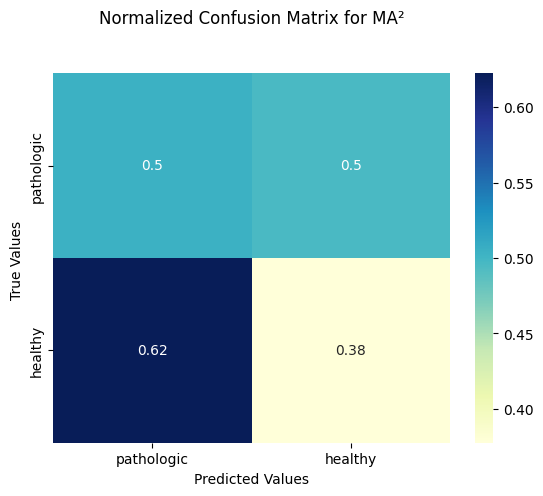

<function matplotlib.pyplot.cla() -> 'None'>

In [16]:
import seaborn as sebrn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random

# conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(7)))
# conf_matrix = [conf_matrix[i]*1.0/sum(conf_matrix[i]) for i in range(len(conf_matrix))]

# Using Seaborn heatmap to create the plot
# fx = sebrn.heatmap(conf_matrix, annot=True, cmap="turbo")

# # labels the title and x, y axis of plot
# fx.set_title("Plotting Confusion Matrix using Seaborn\n\n")
# fx.set_xlabel("Predicted Values")
# fx.set_ylabel("Actual Values ")

# # labels the boxes
# fx.xaxis.set_ticklabels(['suprised', 'afraid', 'disgust', 'happy', 'sad', 'angry', 'neutral'])
# fx.yaxis.set_ticklabels(['suprised', 'afraid', 'disgust', 'happy', 'sad', 'angry', 'neutral'])

# atlas.show()

#### 混淆矩阵画图
print ('cm_total:', cm_t)

print ('1:', cm_t[0])
print ('2:', sum(cm_t[0]))

conf_matrix = [cm_t[i]*1.0/sum(cm_t[i]) for i in range(len(cm_t))]

# conf_matrix = cm_total

print ('conf_matrix:', conf_matrix)
fx = sebrn.heatmap(conf_matrix, annot=True, cmap="YlGnBu")
# fx = sebrn.heatmap(cm_t, annot=True, cmap="YlGnBu")

# sn.heatmap(cm_total,annot=True)

fx.set_title("Normalized Confusion Matrix for MA²\n\n")
# fx.set_title("Confusion Matrix for MA²\n\n")
#
fx.set_xlabel("Predicted Values")
fx.set_ylabel("True Values ")

fx.xaxis.set_ticklabels(['pathologic', 'healthy',])
fx.yaxis.set_ticklabels(['pathologic', 'healthy',])
plt.savefig("MA2_con", dpi=330)
plt.show()

plt.cla
